# Lending Club Case Study
### by Ayush and Nivedita

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [ ]:
loan_df = pd.read_csv('loan.csv', low_memory=False)

In [ ]:
loan_df.head()

In [ ]:
loan_df.shape

- Observation: There are 39k+ rows and 100+ columns

In [ ]:
loan_df.info()

In [ ]:
loan_df.describe()

Observation 
- There seem to be columns which have most values missing
- These can be dropped

---

## Feature Extraction
- We will choose the required columns for anlysis and drop the rest
- We will also drop columns with more than 90% missing values

### Null Value Analysis
- Choosing between imputing or dropping values based on threshold

In [ ]:
# ?loan_df.dropna

#### Columns - Null Value Analysis

##### Dropping columns where all values are missing

In [ ]:
loan_df.dropna(how='all', axis=1, inplace=True)

In [ ]:
loan_df.shape

In [ ]:
df_checkpoint = loan_df.copy()

In [ ]:
loan_df.shape

##### Dropping columns which only have one type of value
- they won't provide any relevants insights (they have only value throughout the column)

In [ ]:
for col in loan_df.columns:
    if len(loan_df[col].unique()) == 1:
        print("dropping:", col, "which contained:", loan_df[col].unique(), 'as the only value')
        loan_df.drop(col, inplace=True, axis=1)

In [ ]:
loan_df.shape

In [ ]:
col_checkpoint = loan_df.copy()

In [ ]:
loan_df.shape

##### Checking percentage of missing values in all columns

In [ ]:
miss_percentage = round(100*(loan_df.isnull().sum()/len(loan_df.id)), 2)

In [ ]:
# list of columns which have missing values
miss_percentage.loc[miss_percentage > 0]

###### Observation: We can see that there are 2 columns with more than 90% missing values and one column with more than 60% missing values.

- First, we remove the columns with more than 90% missing values

In [ ]:
loan_df.drop(list(miss_percentage[miss_percentage >= 90].index), axis=1, inplace=True)

- Next, we check what kind of values does mths_since_last_delinq has.

In [ ]:
loan_df.mths_since_last_delinq.describe()

In [ ]:
loan_df.mths_since_last_delinq.value_counts()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

loan_df.mths_since_last_delinq.value_counts().plot(kind='hist', ax=ax1)
loan_df.mths_since_last_delinq.value_counts()[0:10].plot(kind='bar', ax=ax2)

plt.show()

In [ ]:
sns.boxplot(x='mths_since_last_delinq', data=loan_df)
plt.show()

#### Note:

This column lets us know the number of months since the borrower's last delinquency.  
Since this is an important metric for loan application, we will be keeping this value.  
However, we are not be imputing the values in this phase. We will do so later if required

In [ ]:
loan_df.shape

###### Observation: about 55% of the columns had no relevant information, and have beend dropped

---

#### Rows - Null Value Analysis

In [ ]:
loan_df.dropna(how='all', axis=0).shape

##### Observation: There are no rows where all values are missing

In [ ]:
loan_df.dropna().shape

In [ ]:
len(loan_df[loan_df.isnull().sum(axis=1) <= 3])

##### Observation: There are no rows with more than 3 missing values, hence no rows need to be dropped

---

### Feature Extraction
- We will analyze the columns and description and decide whether they are relevant for our analysis or not

In [ ]:
loan_df.columns

##### Dropping customer behavior columns which are not present at the time of loan application

In [ ]:
all_cust_behav_col = ['collection_recovery_fee','delinq_2yrs','earliest_cr_line','inq_last_6mths','last_credit_pull_d','last_pymnt_amnt','last_pymnt_d','open_acc','out_prncp','out_prncp_inv','pub_rec','recoveries','revol_bal','revol_util','total_acc','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']
loan_df.drop(all_cust_behav_col, axis=1, inplace=True)

##### After analyzing the column description we have decided to drop some columns

| Column          | Reason                                |
|-----------------|---------------------------------------|
| member_id       | similar to id                         |
| funded_amnt     | Data Unavailable when loan is applied |
| funded_amnt_inv | Data Unavailable when loan is applied |
| url             | not required for analysis             |
| desc            | not important for reducing risk       |
| title           | similar to purpose                    |


In [ ]:
loan_df.drop(['member_id', 'funded_amnt', 'funded_amnt_inv', 'url', 'desc', 'title'], axis=1, inplace=True)

In [ ]:
loan_df.shape

In [ ]:
loan_df.columns

##### For the analysis, there is no particular relevance of the `id` column, hence dropping it

In [ ]:
loan_df.drop(['id'], axis=1, inplace=True)

##### Looking closely at the data, some of the columns are filled with one value or NaN, so we will drop these as well

In [ ]:
loan_df.collections_12_mths_ex_med.unique()

In [ ]:
loan_df.chargeoff_within_12_mths.unique()

In [ ]:
loan_df.tax_liens.unique()

In [ ]:
loan_df.drop(['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens'], axis=1, inplace=True)

In [ ]:
loan_df.shape

###### Observation: ~17% columns remain after feature selection

##### As a final step we check for correlation between the numeric columns

In [ ]:
loan_df.corr()

In [ ]:
ax = sns.heatmap(
    loan_df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### Observation: 
- Installament and Loan Amount are positively correlated (strong)
- dti and annual income are negatively correlated (weak)

In [ ]:
loan_df.head()

In [ ]:
loan_df.loan_status.unique()

In [ ]:
loan_df[loan_df.loan_status == 'Current'].shape

##### Note: We know that loan applications whose loan_status is Current are not relevant as these applicants cannot be classified as defaulters / non-defaulters as of now and hence these rows can be dropped

In [ ]:
loan_df = loan_df[~(loan_df.loan_status == 'Current')]

In [ ]:
loan_df.head()

In [ ]:
loan_df.shape

###### Observation: Approximately 2.8% rows have been dropped from the data set

---

### Imputing Missing Values

In [ ]:
miss_percentage = round(100*(loan_df.isnull().sum()/len(loan_df)), 2)

##### The following columns have missing values which can be imputed

In [ ]:
miss_percentage.loc[miss_percentage > 0].index.to_list()

In [ ]:
miss_percentage.loc[miss_percentage > 0]

#### Employee Title

In [ ]:
loan_df.emp_title.value_counts()

In [ ]:
loan_df.emp_title.value_counts()[0:10].plot(kind='bar')
plt.show()

In [ ]:
loan_df.emp_title.mode()

##### Note: Dropping emp_title
6% of the data (~1800 entries) is missing in emp_title, however, the most frequenty occuring emp_title (US Army) is ~0.44% (134 entries), hence filling this column with mode will skew the data.   
Moreover, many of the emp_titles are in small numbers, so it may not be fruitful to analyze this column.

In [ ]:
loan_df.drop(['emp_title'], axis=1, inplace=True)

In [ ]:
loan_df.shape

---

#### Employee Length (length of employment)

In [ ]:
loan_df.emp_length.value_counts()

##### Normalizing Employee Length
- Remove years
- Remove year
- Replace < 1 with 0
- Replace 10+ with 10
- convert to numeric data

In [ ]:
def clean_up(x):
    str_x = str(x)
    if str(x) == 'nan':
        return x
    else:
        normalized = str_x.replace('years', '').replace('year', '').replace('< 1', '0').replace('10+', '10')
        return int(normalized)

In [ ]:
loan_df.emp_length = loan_df.emp_length.apply(clean_up)

In [ ]:
loan_df.emp_length.value_counts()

In [ ]:
100*loan_df.emp_length.value_counts()/sum(loan_df.emp_length.value_counts())

In [ ]:
loan_df.emp_length.isnull().sum()

In [ ]:
loan_df.emp_length.describe()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

loan_df.emp_length.value_counts().plot(kind='bar', ax=ax1)
sns.boxplot(x='emp_length', data=loan_df, ax=ax2)
# sns.kdeplot(x='emp_length', data=loan_df, ax=ax3)
loan_df.emp_length.plot(kind='kde', ax=ax3)

plt.show()

##### Imputing null values of emp_length with mode
- Looking at the plots, it is more likely that the missing values will be filled with 10 (mode)
- This was originally categorical data, which is usually filled with mode

In [ ]:
loan_df.emp_length.fillna(loan_df.emp_length.mode()[0], inplace=True)

In [ ]:
loan_df.emp_length.isnull().sum()

In [ ]:
loan_df.emp_length.value_counts()

##### Checking impact of imputing with mode via plots

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

loan_df.emp_length.value_counts().plot(kind='bar', ax=ax1)
sns.boxplot(x='emp_length', data=loan_df, ax=ax2)
# sns.kdeplot(x='emp_length', data=loan_df, ax=ax3)
loan_df.emp_length.plot(kind='kde', ax=ax3)

plt.show()

##### Observation: The plots look similar before and after imputation, hence filling with mode is a good approach.

---

#### Public Bankruptcies

In [ ]:
loan_df.pub_rec_bankruptcies.value_counts()

In [ ]:
loan_df.pub_rec_bankruptcies.isnull().sum()

##### Imputing the missing values for public bankruptcies with 0 (mode) as out of 38k+ records 36k+ records are filled with 0

In [ ]:
loan_df.pub_rec_bankruptcies.fillna(loan_df.pub_rec_bankruptcies.mode()[0], inplace=True)

In [ ]:
loan_df.pub_rec_bankruptcies.isnull().sum()

In [ ]:
loan_df.pub_rec_bankruptcies.value_counts()

---

In [ ]:
loan_df.info()

##### Observation: 
- There are total 38577 records in the data
- All null values have been imputed except for mths_since_last_delinq

---


### Derived Columns

#### Converting issue_d column to Date Time format
- this will help in adding month and year columns

In [ ]:
loan_df.issue_d.head()

In [ ]:
loan_df.issue_d = pd.to_datetime(loan_df.issue_d, format="%b-%y")

In [ ]:
loan_df['month'] = pd.DatetimeIndex(loan_df.issue_d).month

In [ ]:
loan_df['year'] = pd.DatetimeIndex(loan_df.issue_d).year

In [ ]:
loan_df.head()

### Normalizing Data

In [ ]:
loan_df.info()

#### Let's look at columns which have "object" as dtype (see [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html))

In [ ]:
loan_df.select_dtypes('object')

##### term - 36 months / 60 months
- convert to 0/1 where 
- 0 represents smaller term length (36 months) & 
- 1 represents larger term length of 60 months

In [ ]:
loan_df.term.value_counts()

In [ ]:
# loan_df.term = loan_df.term.apply(lambda x: float(x.replace('36 months', 0).replace('60 months', 1)))

In [ ]:
loan_df.term.head()

---

##### interest rate
- convert to numeric by dropping percentage

In [ ]:
loan_df.int_rate.value_counts().head()

In [ ]:
loan_df.int_rate = loan_df.int_rate.apply(lambda x: float(x.replace('%', '')))

In [ ]:
loan_df.int_rate.value_counts().head()

---

##### Home Ownersip
- replace NONE with RENT

In [ ]:
loan_df.home_ownership.value_counts()

###### Imputing NONE with mode (i.e. RENT)

In [ ]:
loan_df.home_ownership = loan_df.home_ownership.apply(lambda x: x.replace('NONE', 'RENT'))

In [ ]:
loan_df.home_ownership.value_counts()

---

##### Verification Status

In [ ]:
loan_df.verification_status.value_counts()

---

##### Loan Status
Since there are two types of categorical values, we can convert them to a numeric type for better analysis
- charged off => 0
- paid => 1

In [ ]:
loan_df.loan_status.value_counts()

In [ ]:
loan_df.loan_status = loan_df.loan_status.apply(lambda x: int(x.replace('Fully Paid', '1').replace('Charged Off', '0')))

In [ ]:
loan_df.loan_status.value_counts()

---

##### Purpose

In [ ]:
loan_df.purpose.value_counts()

---

##### Zip Code
- convert to numeric by removing xx

In [ ]:
loan_df.zip_code.value_counts().head()

In [ ]:
loan_df.zip_code = loan_df.zip_code.apply(lambda x: int(x.replace('xx', '')))

In [ ]:
loan_df.zip_code.value_counts().head()

---

##### State (Address State - US)

In [ ]:
loan_df.addr_state.value_counts().head()

---

##### Grade - convert to numeric for correlation / other analysis?

In [ ]:
loan_df.grade.value_counts()

---

##### Sub Grade - convert to numeric?

In [ ]:
loan_df.sub_grade.value_counts().head()

###### Observation: Subgrade contains grade information as well

In [ ]:
loan_df.loc[:,['grade', 'sub_grade']]

In [ ]:
#loan_df['sub_grade_num'] = loan_df.sub_grade.apply(lambda x: x[1])

In [ ]:
#loan_df.loc[:,['grade', 'sub_grade', 'sub_grade_num']]

In [ ]:
loan_df.select_dtypes('object')

In [ ]:
loan_df.corr()

In [ ]:
plt.figure(figsize=(10,8))

ax = sns.heatmap(
    loan_df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

---

## Univariate Analysis
- Perform univariate analysis on each of the columns

In [ ]:
loan_df.info()

##### Loan Amount

In [ ]:
loan_df.loan_amnt.describe()

##### Observation: The minimum loan applied is 500USD and maximum loan applied is 35000 USD

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

plt.suptitle('Loan Amount Distribution')
sns.histplot(loan_df.loan_amnt, bins=7, ax=ax1)
loan_df.loan_amnt.value_counts()[0:10].plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_xlabel('Loan Amount (Top 10)')
ax2.set_ylabel('Number of Applicants')
ax1.set_xlabel('Loan Amount (Range)')
ax1.set_ylabel('Number of Applicants')
plt.show()

Observations:
- Most people are applying for a loan within a range of 5000 - 10000 USD

---


##### Term

In [ ]:
loan_df.term.describe()

In [ ]:
# loan_df.term = loan_df.term.apply(lambda x: float(str(x).replace('36', '0').replace('60', '1')))

In [ ]:
loan_df.term.value_counts()

In [ ]:

fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

loan_df.term.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
plt.show()


##### Most people choose 36 months term loan

---

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

plt.suptitle('Loan Amount Distribution')
sns.histplot(loan_df.loan_amnt, bins=7, ax=ax1)
loan_df.loan_amnt.value_counts()[0:10].plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_xlabel('Loan Amount (Top 10)')
ax2.set_ylabel('Number of Applicants')
ax1.set_xlabel('Loan Amount (Range)')
ax1.set_ylabel('Number of Applicants')
plt.show()

In [ ]:
col_continous = []
for col in loan_df:
    if len(loan_df[col].unique()) > 10:
        print(col, ':',len(loan_df[col].unique()))
        col_continous.append(col)
print(col_continous)

In [ ]:
def plot_continous(loan_df, column):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

#     plt.suptitle('Loan Amount Distribution')
    try:
        sns.histplot(loan_df[column], bins=7, ax=ax1)
    except:
        pass
    try:
        loan_df[column].value_counts()[0:10].plot(kind='bar', ax=ax2)
#         ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    except:
        pass
    try:
        sns.boxplot(x=column, data=loan_df, ax=ax3)
    except:
        pass
#     ax2.set_xlabel('Loan Amount (Top 10)')
#     ax2.set_ylabel('Number of Applicants')
#     ax1.set_xlabel('Loan Amount (Range)')
#     ax1.set_ylabel('Number of Applicants')
    plt.show()

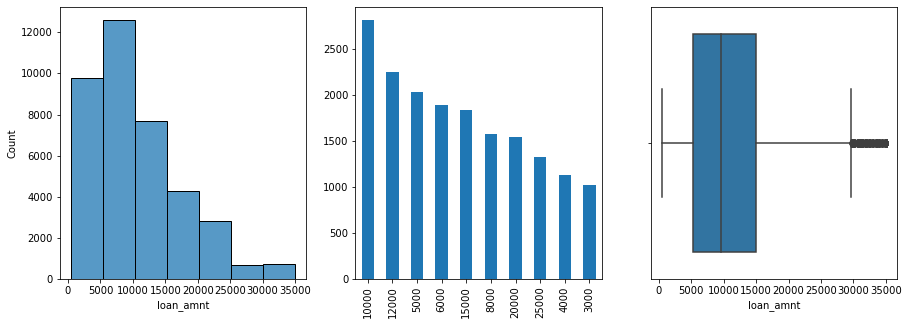

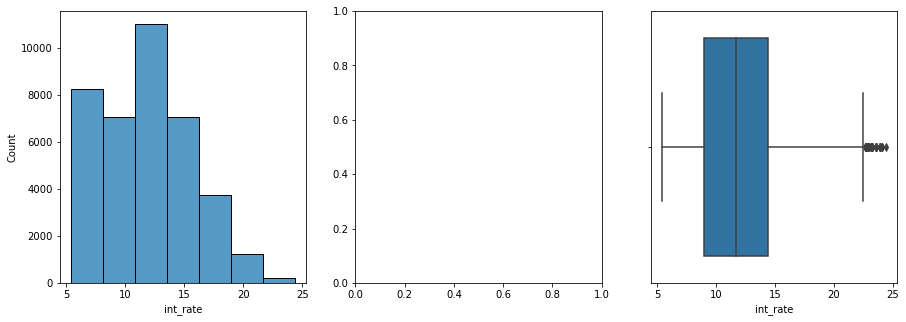

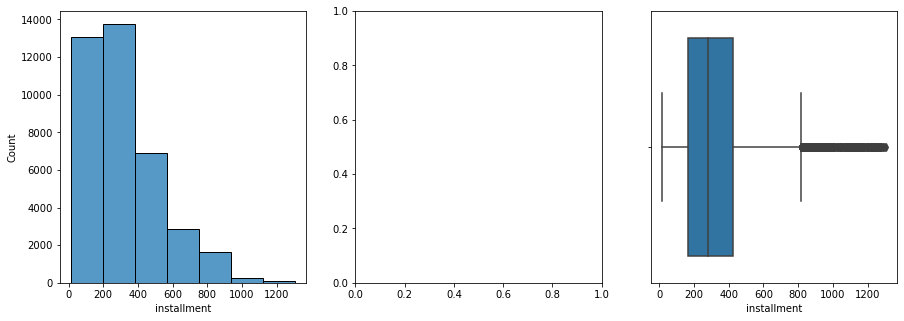

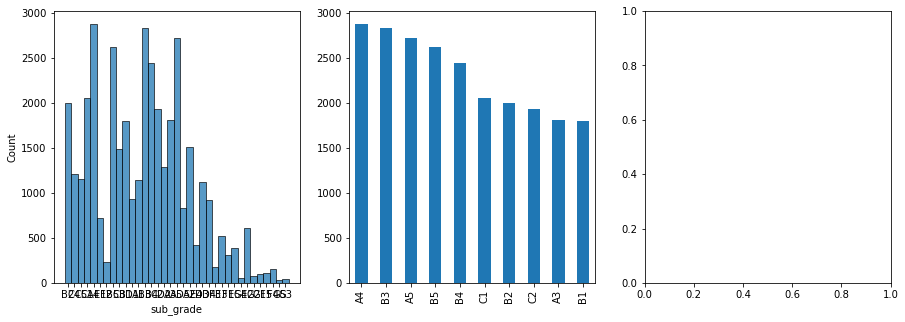

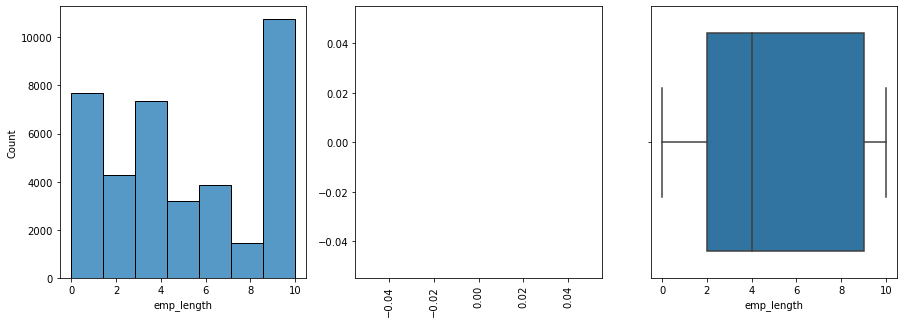

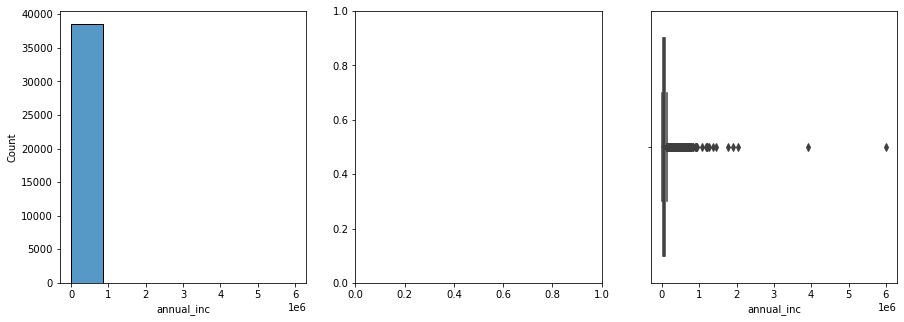

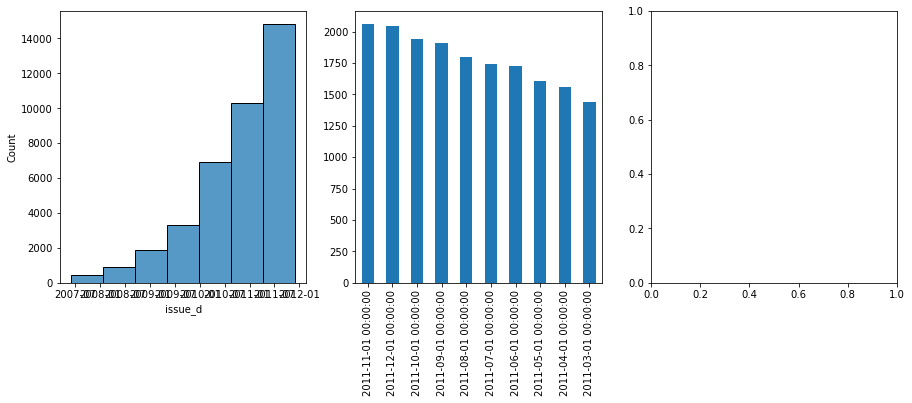

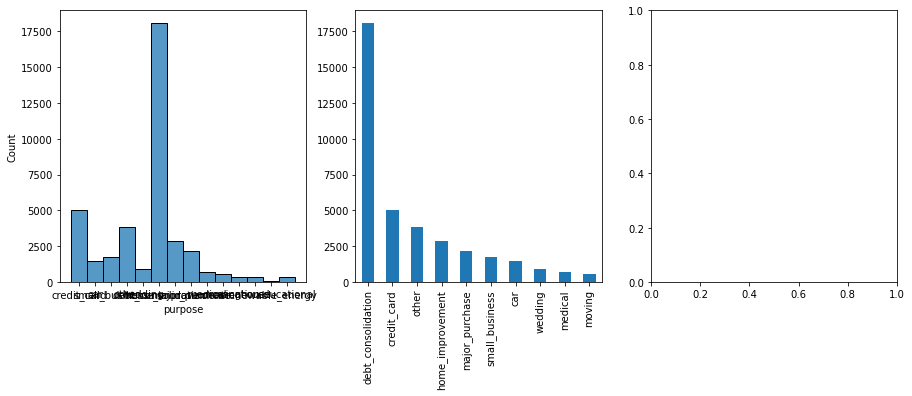

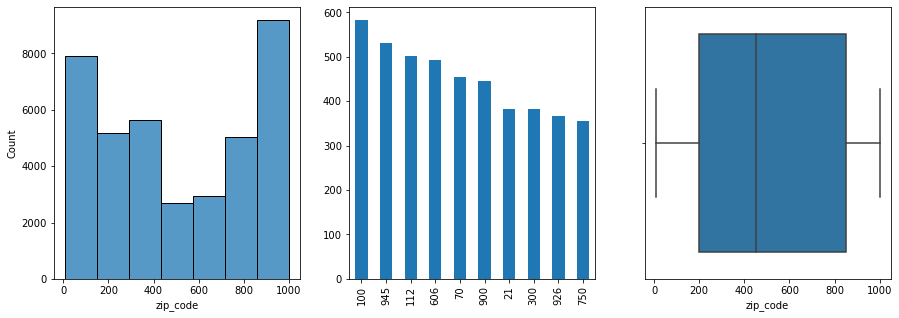

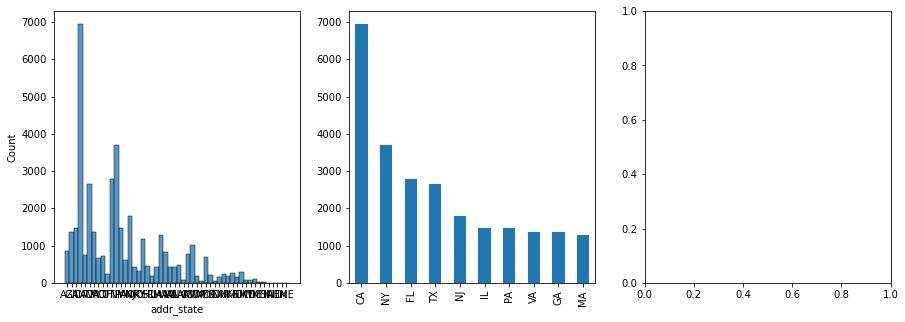

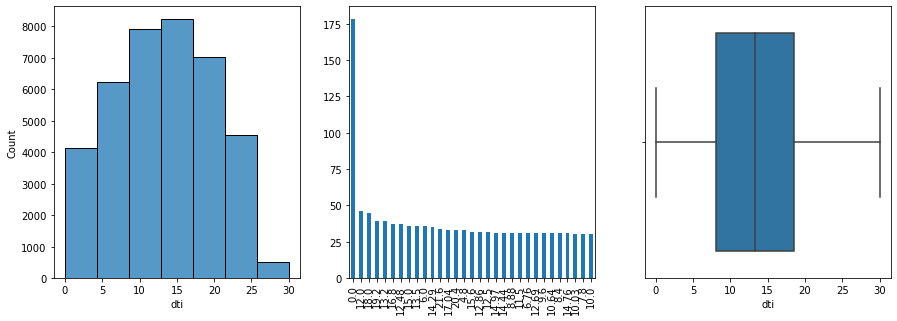

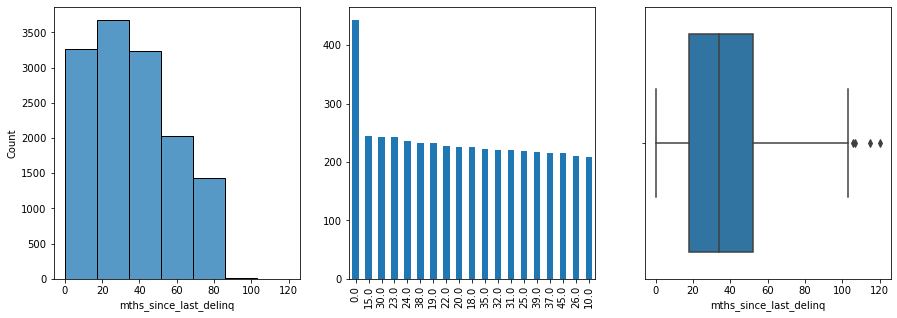

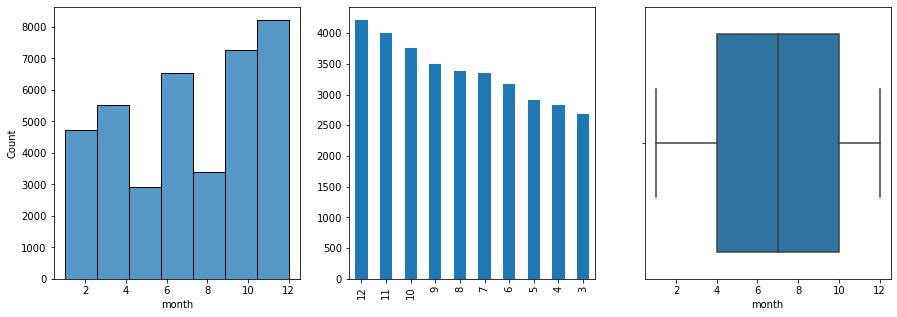

In [157]:
import traceback

for i in col_continous:
    try:
        plot_continous(loan_df, i)
    except:
        print('cannot plot for', i)
#         print(traceback.format_exc())

In [ ]:
for i in col_continous:
    try:
        sns.boxplot(x=i, data=loan_df)
        plt.show()
    except:
        print('issue in', i)

In [ ]:
loan_df.annual_inc.value_counts()

In [ ]:
loan_df.annual_inc.describe()

In [ ]:
sns.histplot(loan_df['annual_inc'], bins=1000)
plt.show()

In [ ]:
loan_df.annual_inc.min()

In [ ]:
loan_df.info()


    
### Plotting for columns which are having value types less than 10


In [147]:
col_continous_small = []
for col in loan_df:
    if len(loan_df[col].unique()) < 10:
        print(col, ':',len(loan_df[col].unique()))
        col_continous_small.append(col)
print(col_continous_small)

term : 2
grade : 7
home_ownership : 4
verification_status : 3
loan_status : 2
pub_rec_bankruptcies : 3
year : 5
['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pub_rec_bankruptcies', 'year']


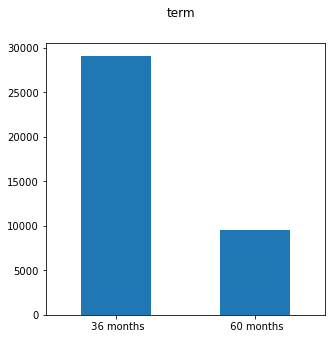

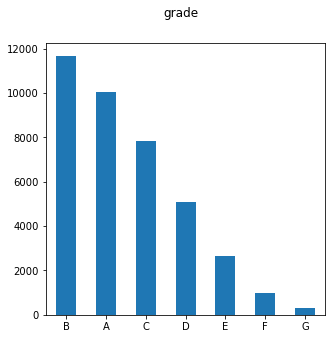

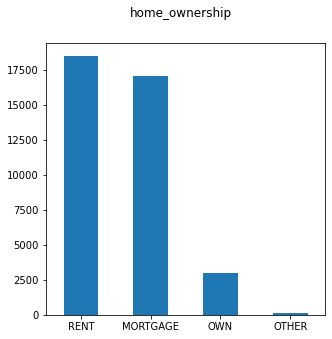

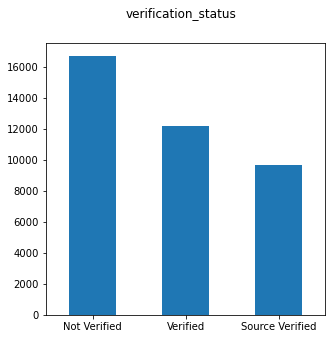

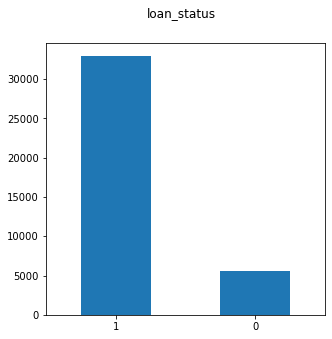

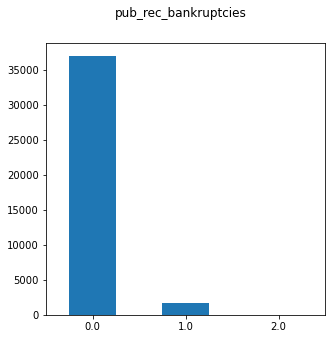

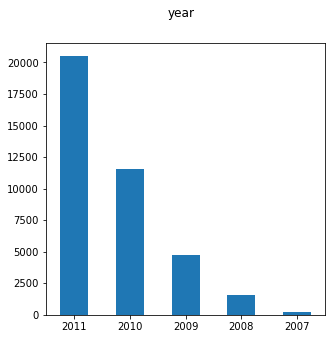

In [156]:
def plot_small(loan_df,i):
    fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
    loan_df[i].value_counts().plot(kind='bar')
    plt.suptitle(i)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
    plt.show()

import traceback

for i in col_continous_small:
    try:
        plot_small(loan_df, i)
    except:
        print('cannot plot for', i)
        


Change lables for loan status

C:\Users\91808\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='loan_amnt', ylabel='Density'>

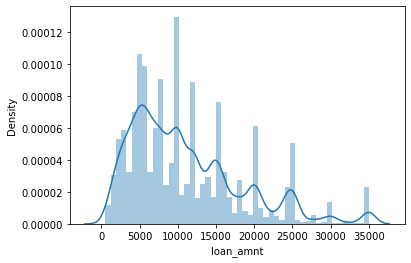

In [160]:
sns.distplot(loan_df['loan_amnt'])

# Bivariate:

In [161]:
loan_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,mths_since_last_delinq,pub_rec_bankruptcies,month,year
0,5000,36 months,10.65,162.87,B,B2,10.0,RENT,24000.0,Verified,2011-12-01,1,credit_card,860,AZ,27.65,NaN,0.0,12,2011
1,2500,60 months,15.27,59.83,C,C4,0.0,RENT,30000.0,Source Verified,2011-12-01,0,car,309,GA,1.00,NaN,0.0,12,2011
2,2400,36 months,15.96,84.33,C,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,1,small_business,606,IL,8.72,NaN,0.0,12,2011
3,10000,36 months,13.49,339.31,C,C1,10.0,RENT,49200.0,Source Verified,2011-12-01,1,other,917,CA,20.00,35.0,0.0,12,2011
5,5000,36 months,7.90,156.46,A,A4,3.0,RENT,36000.0,Source Verified,2011-12-01,1,wedding,852,AZ,11.20,NaN,0.0,12,2011


### Loan amount take over years

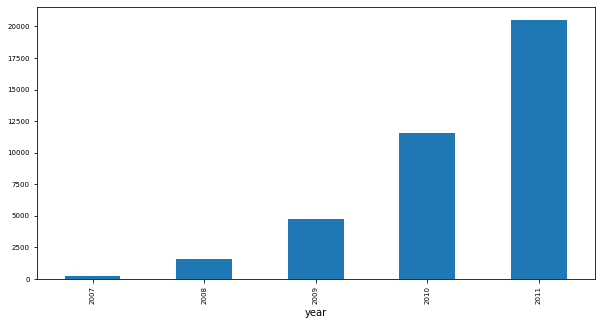

In [163]:
plt.figure(figsize=(10,5))
loan_df.groupby('year').loan_amnt.count().plot(kind='bar', fontsize=7)
plt.show()

Loan amount vs annual income

In [169]:
loan_df.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

C:\Users\91808\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


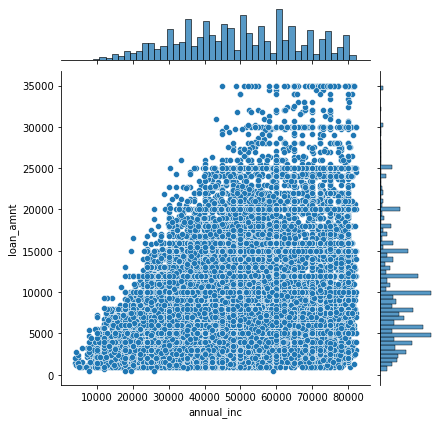

In [171]:
sns.jointplot('annual_inc', 'loan_amnt', loan_df[loan_df['annual_inc']<82000])
plt.show()

---

Loan amount vs grade

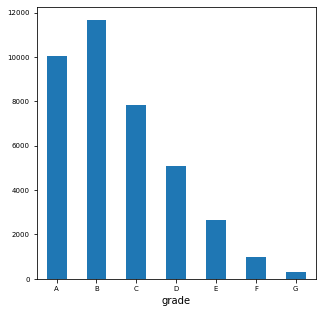

In [176]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
loan_df.groupby('grade').loan_amnt.count().plot(kind='bar', fontsize=7)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
plt.show()

Loan amount vs employee length of service

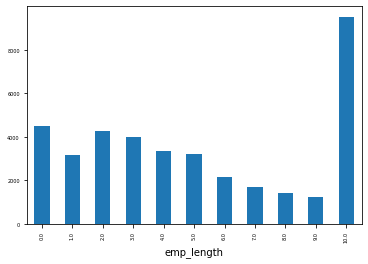

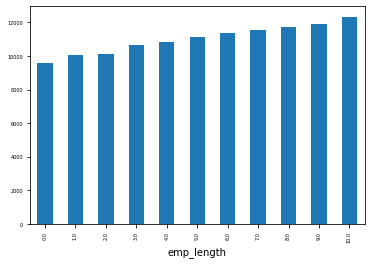

In [183]:
#fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
loan_df.groupby('emp_length').loan_amnt.count().plot(kind='bar', fontsize=5)
plt.show()
loan_df.groupby('emp_length').loan_amnt.mean().plot(kind='bar', fontsize=5)

#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
plt.show()

# References
- https://seaborn.pydata.org/generated/seaborn.kdeplot.html
- https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/
- https://www.w3schools.com/python/python_datetime.asp
- https://www.codegrepper.com/code-examples/python/extract+month+from+datetime+pandas
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html